In [1]:
import pandas as pd 
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,confusion_matrix,mean_squared_error,roc_curve
import lightgbm as lgb
from wordcloud import WordCloud
import nltk
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.text import TextCollection

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [3]:
main_credit_data = pd.read_csv('../input/modified-credit-main-data/modified_credit_main_data.csv')
main_credit_data = reduce_memory(main_credit_data)
main_credit_data = main_credit_data.rename(columns=lambda x: x.replace(' ', '_'))
main_credit_data['Auto_Purpose_Tag_Name'] = main_credit_data['Auto_Purpose_Tag_Name'].str.lower()
main_credit_data.loc[main_credit_data['Auto_Purpose_Tag_Name']!='salary or wages (main)','Auto_Purpose_Tag_Name']=0
main_credit_data.loc[main_credit_data['Auto_Purpose_Tag_Name']=='salary or wages (main)','Auto_Purpose_Tag_Name']=1
main_credit_data['Year_of_Birth'] = main_credit_data['Year_of_Birth'].fillna(float(main_credit_data['Year_of_Birth'].median()))
main_credit_data['Year_of_Birth'] = main_credit_data['Year_of_Birth'].apply(lambda x: float(main_credit_data['Year_of_Birth'].median()) if x <= float(1939.0) else x)
main_credit_data.drop('t_month',axis=1,inplace=True)

Initial df memory usage is 215.62 MB for 18 columns
Final memory usage is: 160.22 MB - decreased by 25.7%


In [4]:
'''#undersampling
count_class_0, count_class_1 = main_credit_data.Auto_Purpose_Tag_Name.value_counts()
from sklearn.utils import shuffle
# Divide by class
df_class_0 = main_credit_data[main_credit_data['Auto_Purpose_Tag_Name'] == 0]
df_class_1 = main_credit_data[main_credit_data['Auto_Purpose_Tag_Name'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
under_sampling_train = pd.concat([df_class_0_under, df_class_1], axis=0)
main_credit_data= shuffle(under_sampling_train)
#X_train = under_sampling_data.drop('Auto_Purpose_Tag_Name',axis=1)
'''

"#undersampling\ncount_class_0, count_class_1 = main_credit_data.Auto_Purpose_Tag_Name.value_counts()\nfrom sklearn.utils import shuffle\n# Divide by class\ndf_class_0 = main_credit_data[main_credit_data['Auto_Purpose_Tag_Name'] == 0]\ndf_class_1 = main_credit_data[main_credit_data['Auto_Purpose_Tag_Name'] == 1]\ndf_class_0_under = df_class_0.sample(count_class_1)\nunder_sampling_train = pd.concat([df_class_0_under, df_class_1], axis=0)\nmain_credit_data= shuffle(under_sampling_train)\n#X_train = under_sampling_data.drop('Auto_Purpose_Tag_Name',axis=1)\n"

'''#oversampling
count_class_0, count_class_1 = main_credit_data.Auto_Purpose_Tag_Name.value_counts()
df_class_0 = main_credit_data[main_credit_data['Auto_Purpose_Tag_Name'] == 0]
df_class_1 = main_credit_data[main_credit_data['Auto_Purpose_Tag_Name'] == 1]
from sklearn.utils import shuffle
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
over_sampling_data = pd.concat([df_class_0, df_class_1_over], axis=0)
main_credit_data= shuffle(over_sampling_data)
’‘’

In [5]:
test_data = pd.read_csv('../input/final-test-data/final_test_data.csv')
test_data = reduce_memory(test_data)
test_data = test_data.rename(columns=lambda x: x.replace(' ', '_'))
test_data['Auto_Purpose_Tag_Name'] = test_data['Auto_Purpose_Tag_Name'].str.lower()
test_data.loc[test_data['Auto_Purpose_Tag_Name']!='salary or wages (main)','Auto_Purpose_Tag_Name']=0
test_data.loc[test_data['Auto_Purpose_Tag_Name']=='salary or wages (main)','Auto_Purpose_Tag_Name']=1
test_data['Year_of_Birth'] = test_data['Year_of_Birth'].fillna(float(test_data['Year_of_Birth'].median()))
test_data['Year_of_Birth'] = test_data['Year_of_Birth'].apply(lambda x: test_data['Year_of_Birth'].median() if x <= float(1939.0) else x)

Initial df memory usage is 77.82 MB for 17 columns
Final memory usage is: 60.65 MB - decreased by 22.1%


In [6]:
main_credit_data['Transaction_Date'] = pd.to_datetime(main_credit_data['Transaction_Date'])
main_credit_data['Transaction_Month'],main_credit_data['Transaction_Day'],main_credit_data['Transaction_Weekday'],main_credit_data['Transaction_weekday_name']= main_credit_data['Transaction_Date'].dt.month,main_credit_data['Transaction_Date'].dt.day,main_credit_data['Transaction_Date'].dt.weekday,main_credit_data['Transaction_Date'].dt.weekday_name
#X_val['Transaction_Date'] = pd.to_datetime(X_val['Transaction_Date'])
#X_val['t_month'],X_val['t_day'],X_val['t_weekday'],X_val['t_weekday_name']= X_val['Transaction_Date'].dt.month,X_val['Transaction_Date'].dt.day,X_val['Transaction_Date'].dt.weekday,X_val['Transaction_Date'].dt.weekday_name
test_data['Transaction_Date'] = pd.to_datetime(test_data['Transaction_Date'])
test_data['Transaction_Month'],test_data['Transaction_Day'],test_data['Transaction_Weekday'],test_data['Transaction_weekday_name']= test_data['Transaction_Date'].dt.month,test_data['Transaction_Date'].dt.day,test_data['Transaction_Date'].dt.weekday,test_data['Transaction_Date'].dt.weekday_name

In [7]:
vectorizer = TfidfVectorizer(analyzer='word',token_pattern=r'\w{1,}',min_df=5,sublinear_tf=True)
text = vectorizer.fit_transform(main_credit_data['Transaction_Description'])
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(text,main_credit_data['Auto_Purpose_Tag_Name'])
import eli5
weight_results = eli5.explain_weights_df(lr,vec = vectorizer,top=50,feature_filter = lambda x:x!='<BIAS>')
words_1 = np.array(weight_results['feature'][31:50])
words = np.append(words_1,weight_results['feature'].tolist()[0])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
poly_features = main_credit_data[['Amount', 'Transaction_Day','Transaction_Weekday', 'User_Reference', 'Auto_Purpose_Tag_Name']]
poly_features_test = test_data[['Amount', 'Transaction_Day','Transaction_Weekday', 'User_Reference']]
poly_target = poly_features['Auto_Purpose_Tag_Name']
poly_features = poly_features.drop(columns = ['Auto_Purpose_Tag_Name'])
from sklearn.preprocessing import PolynomialFeatures
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['Amount', 'Transaction_Day','Transaction_Weekday', 'User_Reference']))
poly_features['Auto_Purpose_Tag_Name'] = poly_target
poly_corrs = poly_features.corr()['Auto_Purpose_Tag_Name'].sort_values()
print(poly_corrs)
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['Amount', 'Transaction_Day','Transaction_Weekday', 'User_Reference']))

User_Reference                                        0.010395
User_Reference^2                                      0.012574
User_Reference^3                                      0.013335
Transaction_Weekday^3                                 0.066661
Transaction_Weekday^2 User_Reference                  0.102186
Transaction_Weekday User_Reference^2                  0.121924
Transaction_Weekday^2                                 0.122097
Transaction_Weekday User_Reference                    0.139460
Transaction_Day User_Reference^2                      0.152343
Amount^3                                              0.161378
Transaction_Weekday                                   0.177631
Transaction_Day User_Reference                        0.180833
Transaction_Day^2 User_Reference                      0.211715
Transaction_Day Transaction_Weekday^2                 0.212918
Transaction_Day Transaction_Weekday User_Reference    0.227098
Amount^2 User_Reference                               0

In [9]:
column_names = poly_corrs.reset_index().tail(12)['index'].tolist()[:10]
previous_columns = main_credit_data.columns.tolist()
columns = list(set(column_names).difference(set(previous_columns))) 
for column in columns:
    main_credit_data['poly_'+column] = poly_features[column]
    test_data['poly_'+column] = poly_features_test[column]

In [10]:
y_train = main_credit_data['Auto_Purpose_Tag_Name']
X_train = main_credit_data.drop('Auto_Purpose_Tag_Name',axis=1)
y_test = test_data['Auto_Purpose_Tag_Name']
X_test = test_data.drop('Auto_Purpose_Tag_Name',axis=1)

In [11]:
year_of_birth = X_train['Year_of_Birth'].unique()
for ye in year_of_birth:
    X_train['year_'+str(ye)] = X_train['Year_of_Birth'].apply(lambda x: 1 if ye==x else 0)
    # X_val['year_'+str(ye)] = X_val['Year_of_Birth'].apply(lambda x: 1 if ye==x else 0)
    X_test['year_'+str(ye)] = X_test['Year_of_Birth'].apply(lambda x: 1 if ye==x else 0)

X_train.drop('Salary_Range',axis=1,inplace=True)
#X_val.drop('Salary_Range',axis=1,inplace=True)
X_test.drop('Salary_Range',axis=1,inplace=True)

gender = X_train['Derived_Gender'].unique()
for ge in gender:
    X_train['gender_'+ge] =  X_train['Derived_Gender'].apply(lambda x: 1 if ge in x else 0)
    #X_val['gender_'+ge] =  X_train['Derived_Gender'].apply(lambda x: 1 if ge in x else 0)
    X_test['gender_'+ge] =  X_test['Derived_Gender'].apply(lambda x: 1 if ge in x else 0)

In [12]:
providers = X_train['Provider_Group_Name'].unique()
for pr in providers:
    X_train['provider_'+pr] = X_train['Provider_Group_Name'].apply(lambda x: 1 if pr in x else 0)
    #X_val['provider_'+pr] = X_val['Provider_Group_Name'].apply(lambda x: 1 if pr in x else 0)
    X_test['provider_'+pr] = X_test['Provider_Group_Name'].apply(lambda x: 1 if pr in x else 0)

account_type=  X_train['Account_Type'].unique()
for ac in account_type:
    X_train[ac+'_account'] =  X_train['Account_Type'].apply(lambda x: 1 if ac in x else 0)
    #X_val[ac+'_account'] =  X_val['Account_Type'].apply(lambda x: 1 if ac in x else 0)
    X_test[ac+'_account'] =  X_test['Account_Type'].apply(lambda x: 1 if ac in x else 0)
    
# Credit_Debit 
X_train.drop('Credit_Debit',axis=1,inplace=True)
#X_val.drop('Credit_Debit',axis=1,inplace=True)
X_test.drop('Credit_Debit',axis=1,inplace=True)

In [13]:
for word in words:
    X_train['word_'+str(word)] = X_train['Transaction_Description'].apply(lambda x: 1 if word in x else 0)
    # X_val['year_'+str(ye)] = X_val['Year_of_Birth'].apply(lambda x: 1 if ye==x else 0)
    X_test['word_'+str(word)] = X_test['Transaction_Description'].apply(lambda x: 1 if word in x else 0)

In [14]:
mbls = X_train['Merchant_Business_Line'].value_counts().head(20).reset_index()['index'].tolist()
for mbl in mbls:
    X_train['Merchant_Business_Line_'+mbl] = X_train['Merchant_Business_Line'].apply(lambda x: 1 if mbl in x else 0)
    #X_val['Merchant_Business_Line_'+mbl] = X_val['Merchant_Business_Line'].apply(lambda x: 1 if mbl in x else 0)
    X_test['Merchant_Business_Line_'+mbl] = X_test['Merchant_Business_Line'].apply(lambda x: 1 if mbl in x else 0)

In [15]:
main_credit_data['Number_of_similar_transactions']=main_credit_data['Number_of_similar_transactions'].apply(lambda x: 12 if x>12 else x)
test_data['Number_of_similar_transactions']=test_data['Number_of_similar_transactions'].apply(lambda x: 12 if x>12 else x)
X_train['Number_of_similar_transactions']=main_credit_data['Number_of_similar_transactions']
X_test['Number_of_similar_transactions']=test_data['Number_of_similar_transactions']
#X_train.drop(['Number_of_similar_transactions'],inplace=True, axis=1)
#X_test.drop(['Number_of_similar_transactions'],inplace=True, axis=1)

In [16]:
X_train.drop(['Unnamed:_0','Account_Reference','Merchant_Business_Line','Year_of_Birth','Derived_Gender','Account_Type','Provider_Group_Name','Manual_Tag_Name','Merchant_Name','Transaction_Date','Transaction_Description','Transaction_weekday_name'],axis=1,inplace=True)
#X_val.drop(['Account_Reference','Merchant_Business_Line','Year_of_Birth','Derived_Gender','Account_Type','Provider_Group_Name','Manual_Tag_Name','Merchant_Name','Transaction_Date','Transaction_Description','t_weekday_name'],axis=1,inplace=True)
X_test.drop(['Unnamed:_0','Account_Reference','Merchant_Business_Line','Year_of_Birth','Derived_Gender','Account_Type','Provider_Group_Name','Manual_Tag_Name','Merchant_Name','Transaction_Date','Transaction_Description','Transaction_weekday_name'],axis=1,inplace=True)

In [17]:
X_train.drop(['poly_Amount User_Reference','poly_Amount Transaction_Weekday^2','poly_Amount Transaction_Day^2','poly_Amount Transaction_Day User_Reference','poly_Amount Transaction_Weekday User_Reference','poly_Amount Transaction_Day Transaction_Weekday','poly_Amount Transaction_Day','poly_Amount User_Reference^2'],axis=1,inplace=True)
X_test.drop(['poly_Amount User_Reference','poly_Amount Transaction_Weekday^2','poly_Amount Transaction_Day^2','poly_Amount Transaction_Day User_Reference','poly_Amount Transaction_Weekday User_Reference','poly_Amount Transaction_Day Transaction_Weekday','poly_Amount Transaction_Day','poly_Amount User_Reference^2'],axis=1,inplace=True)

In [18]:
import gc
del main_credit_data,test_data
gc.collect()

308

In [19]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer().fit(X_train)
LR_X_train = normalizer.transform(X_train)   
LR_X_test = normalizer.transform(X_test)  

In [20]:
from sklearn.linear_model import LogisticRegression 
clf_X = LogisticRegression(C=229.105,random_state=0, solver='sag',class_weight='balanced').fit(LR_X_train, y_train)
logist_y_pred = clf_X.predict_proba(LR_X_test)[:,1]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [21]:
from sklearn.metrics import roc_auc_score
auc_lr = roc_auc_score(y_test,logist_y_pred)
auc_lr

0.870822735598282

In [22]:
print(classification_report(y_test,logist_y_pred.round()))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90    480668
           1       0.62      0.46      0.53    119332

    accuracy                           0.84    600000
   macro avg       0.75      0.70      0.72    600000
weighted avg       0.82      0.84      0.83    600000



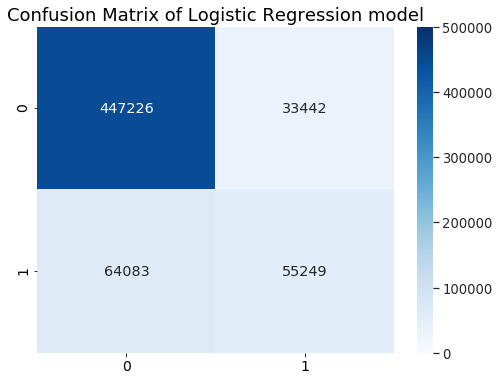

In [23]:
f, ax=plt.subplots(figsize = (8,6))
sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, logist_y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=True,vmin=0,vmax=500000)
plt.title('Confusion Matrix of Logistic Regression model',fontsize=18)
ax.tick_params(labelsize=14)


In [24]:
LR_test = pd.DataFrame(columns = ['y_test','y_pred'])
LR_test['y_test'] = y_test
LR_test['y_pred'] = logist_y_pred
LR_test.to_csv('LR_test.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'''plt.rcParams['figure.figsize']=(12,7)
plt.style.use("fivethirtyeight")
#fpr_wl, tpr_wl, thresholds_keras_wl = roc_curve(y_test,logist_y_pred_without_L)
fpr, tpr, thresholds = roc_curve(y_test,logist_y_pred)
#auc_lr_wl = roc_auc_score(y_test,logist_y_pred_without_L)
auc_lr = roc_auc_score(y_test,logist_y_pred)
#print("The AUC of LR model without L_distance feature: ", auc_lr_wl)
print("The AUC of LR model using initial features: ", auc_lr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_wl, tpr_wl, label='LR without L_distance(area = {:.3f})'.format(auc_lr_wl))
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Logistic Regression model all selected features')
plt.legend(loc='best')
'''

'''plt.rcParams['figure.figsize']=(5,5)
plt.style.use("fivethirtyeight")
cm = confusion_matrix(y_test, logist_y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('Confusion Matrix of Logistic Regression model using all selected features',fontsize=15)
#plt.legend(loc='best')
'''

'''from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
'''

'''import gc
del X_train,X_test
gc.collect()
'''

'''tuned_parameters={'C':stats.expon(scale=100)}
clf=RandomizedSearchCV(LogisticRegression(penalty='l2',solver='sag',class_weight='balanced',max_iter=500 ),
                   tuned_parameters,cv=3,scoring='roc_auc',n_iter=50)
 
clf.fit(LR_X_train,y_train)
print('best parameters:',clf.best_estimator_)
print(classification_report(y_test,clf.predict(LR_X_test)))
print(roc_auc_score(y_test,clf.predict_proba(LR_X_test)[:,1]))
'''
